In [147]:
import os, glob, re, math, random
import time
from scipy.io import wavfile
import cPickle as pickle
import numpy as np
import pandas as pd
from python_speech_features import logfbank, fbank

import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

#### load all the wav files

In [3]:
train_main_path = '/Users/matt.meng/data/speech_competition/train/audio'
wav_files = glob.glob(os.path.join(train_main_path, "*", "*.wav"))

In [4]:
wav_files[21]

'/Users/matt.meng/data/speech_competition/train/audio/bed/01b4757a_nohash_1.wav'

In [5]:
sample_rate, samples = wavfile.read(wav_files[20])

In [6]:
sample_rate, len(samples)

(16000, 16000)

#### process the raw waveforms

In [441]:
def pad_raw_waveform(raw_waveform, length=16000, padding_value=0):        
        if len(raw_waveform) == length:
            return raw_waveform
        raw_waveform = np.append(raw_waveform, np.zeros((length - len(raw_waveform))))
        return raw_waveform
    
def smooth_by_moving_average(raw_waveform, window_size):
    cumsum = np.cumsum(np.abs(raw_waveform))
    diff_sum = cumsum[window_size:] - cumsum[:-window_size]
    return diff_sum[window_size-1:] / window_size        

In [472]:
def collect_wav_files_by_label(data_path, label='_background_noise_'):
    if not isinstance(data_path, str):
        raise ValueError('need a data path')
    wav_files = glob.glob(os.path.join(data_path, "*", "*.wav"))
    if len(wav_files) == 0:
        raise ValueError('{} is an empty data path'.format(data_path))
    
    selected_wav_files = []
    for wav_file in wav_files:
        word = re.search('.*/([^/]+)/.*.wav', wav_file).group(1).lower()
        if word == label:
            selected_wav_files.append(wav_file)
    return selected_wav_files

def add_element(file_dict, key, file_name):
    if key not in file_dict:
        file_dict[key] = [file_name]
    else:
        file_dict[key].append(file_name)

def plot_spectrum(filter_banks, sample_rate):
    fig, ax = plt.subplots(figsize=(18, 4))
    plt.imshow(np.flipud(filter_banks.T), cmap=cm.jet, aspect='auto', extent=[0, 1., 0, sample_rate/2/1000])
    plt.colorbar()
    plt.ylabel('Frequency (kHz)', fontsize=16)
    plt.xlabel('Time (s)', fontsize=16)    
        
def collect_variable_length_files(wav_files, norm_length=16000):
    length_dict = {}
    wav_file_dict = {}
    for wav_file in wav_files:
        sample_rate, samples = wavfile.read(wav_file)
        word = re.search('.*/([^/]+)/.*.wav', wav_file).group(1).lower()
        sample_length = len(samples) 
        if sample_length != norm_length:
            if word not in length_dict:
                length_dict[word] = {}
                wav_file_dict[word] = {}
            length_dict[word][sample_length] = length_dict[word].get(sample_length, 0) + 1
            add_element(wav_file_dict[word], sample_length, wav_file)
    return length_dict, wav_file_dict

In [24]:
length_dict_, wav_file_dict_ = collect_variable_length_files(wav_files)

#### show the variable-length files

In [198]:
length_dict_

{'_background_noise_': {960000: 2,
  978488: 1,
  980062: 1,
  988891: 1,
  1522930: 1},
 'bed': {7510: 1,
  8192: 2,
  8875: 2,
  9660: 1,
  10403: 3,
  10923: 7,
  11146: 5,
  11264: 1,
  11606: 5,
  11889: 8,
  11947: 1,
  12288: 6,
  12630: 2,
  12632: 9,
  12971: 23,
  13142: 1,
  13375: 10,
  13654: 16,
  13995: 1,
  14118: 13,
  14336: 19,
  14490: 1,
  14507: 1,
  14861: 22,
  15019: 26,
  15360: 2,
  15604: 16,
  15702: 24,
  15872: 1},
 'bird': {7851: 1,
  8192: 3,
  8875: 3,
  8917: 1,
  9558: 4,
  10240: 3,
  10403: 5,
  10923: 7,
  11146: 6,
  11606: 7,
  11776: 1,
  11889: 9,
  11947: 1,
  12288: 3,
  12632: 9,
  12971: 9,
  13375: 22,
  13654: 9,
  14118: 14,
  14166: 1,
  14336: 15,
  14861: 23,
  15019: 19,
  15360: 1,
  15531: 1,
  15604: 12,
  15702: 21},
 'cat': {8174: 1,
  8192: 1,
  8875: 3,
  9558: 1,
  9660: 2,
  10240: 5,
  10403: 1,
  10923: 4,
  11146: 6,
  11264: 1,
  11606: 16,
  11776: 1,
  11889: 6,
  12288: 11,
  12632: 6,
  12971: 9,
  13142: 1,
  13375

In [365]:
wav_file_dict_['zero'][7431]

['/Users/matt.meng/data/speech_competition/train/audio/zero/a40c62f1_nohash_0.wav']

In [317]:
file_name = '/Users/matt.meng/data/speech_competition/train/audio/bird/772db621_nohash_0.wav'
sample_rate, samples = wavfile.read(file_name)

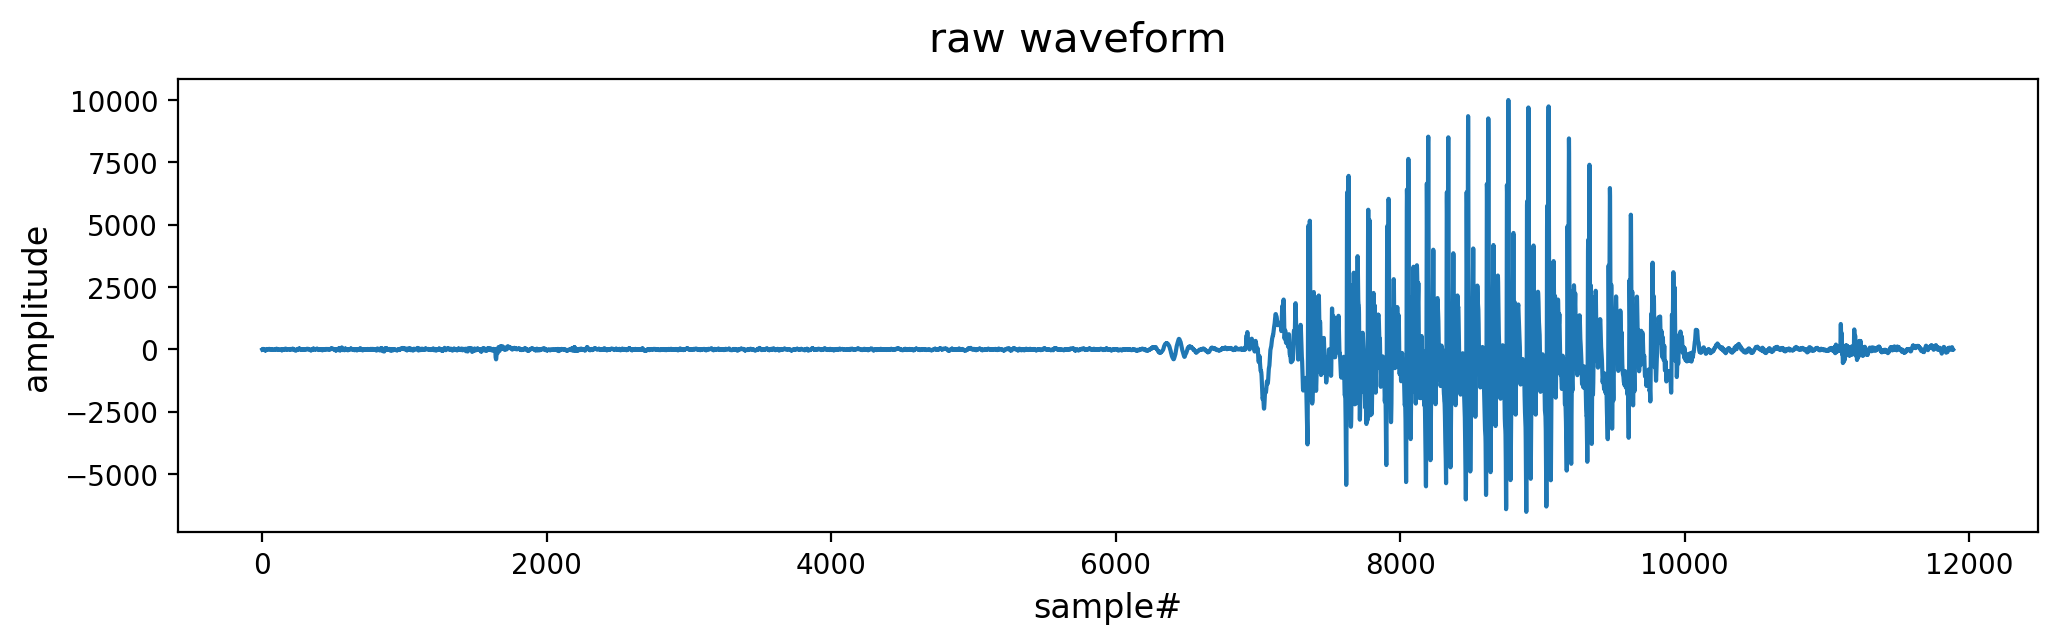

In [323]:
plot_waveform(samples)

In [319]:
ipd.Audio(samples, rate=sample_rate)

### check the backgroun noise

In [473]:
background_wav_files = collect_wav_files_by_label(train_main_path)

In [474]:
background_wav_files

['/Users/matt.meng/data/speech_competition/train/audio/_background_noise_/doing_the_dishes.wav',
 '/Users/matt.meng/data/speech_competition/train/audio/_background_noise_/dude_miaowing.wav',
 '/Users/matt.meng/data/speech_competition/train/audio/_background_noise_/exercise_bike.wav',
 '/Users/matt.meng/data/speech_competition/train/audio/_background_noise_/pink_noise.wav',
 '/Users/matt.meng/data/speech_competition/train/audio/_background_noise_/running_tap.wav',
 '/Users/matt.meng/data/speech_competition/train/audio/_background_noise_/white_noise.wav']

In [228]:
file_name = background_wav_files[4]
print file_name
sample_rate, samples = wavfile.read(file_name)

/Users/matt.meng/data/speech_competition/train/audio/_background_noise_/running_tap.wav


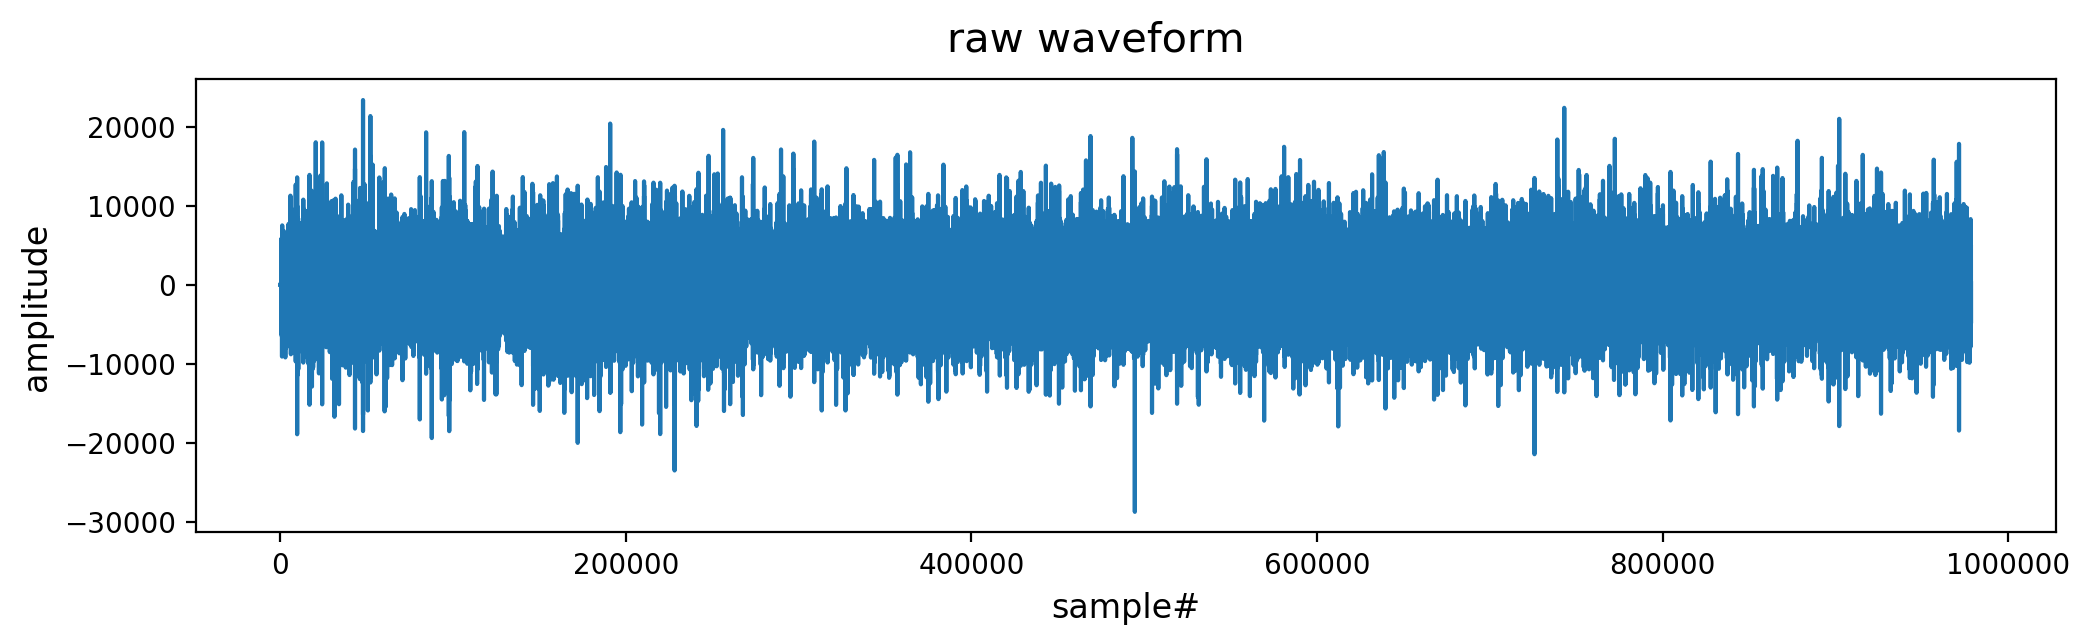

In [229]:
plot_waveform(samples)

In [185]:
ipd.Audio(samples, rate=sample_rate)

In [181]:
fbank_features = logfbank(samples, sample_rate)

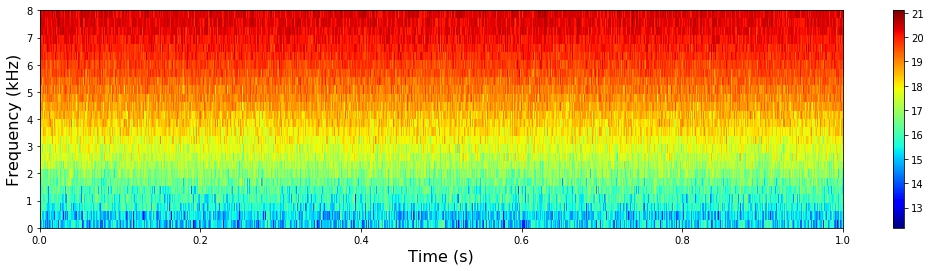

In [182]:
plot_spectrum(fbank_features, sample_rate)

#### check the white noise generator

In [357]:
def white_noise(file_name_, length, norm=300):
    sample_rate, samples = wavfile.read(file_name_)
    if len(samples) < length:
        #print 'total length is {}'.format(len(samples))
        max_amplitude = np.max(samples)
        samples = samples.astype(float)*(norm/max_amplitude)
        return samples.astype(int)
    start_index = random.randrange(0, len(samples)-length)
    #print 'the start_index: ', start_index
    selected_samples = samples[start_index:(start_index+length)].astype(float)
    max_amplitude = np.max(selected_samples)
    selected_samples = selected_samples*(norm/max_amplitude)
    return selected_samples.astype(int)


In [380]:
#file_name = '/Users/matt.meng/data/speech_competition/train/audio/bird/ae71797c_nohash_0.wav'
file_name = '/Users/matt.meng/data/speech_competition/train/audio/_background_noise_/dude_miaowing.wav'
print file_name
noise = white_noise(file_name, norm=50, length=15000)

/Users/matt.meng/data/speech_competition/train/audio/_background_noise_/dude_miaowing.wav


In [372]:
noise

array([-36, -10,  -1, ...,  -3, -16, -16])

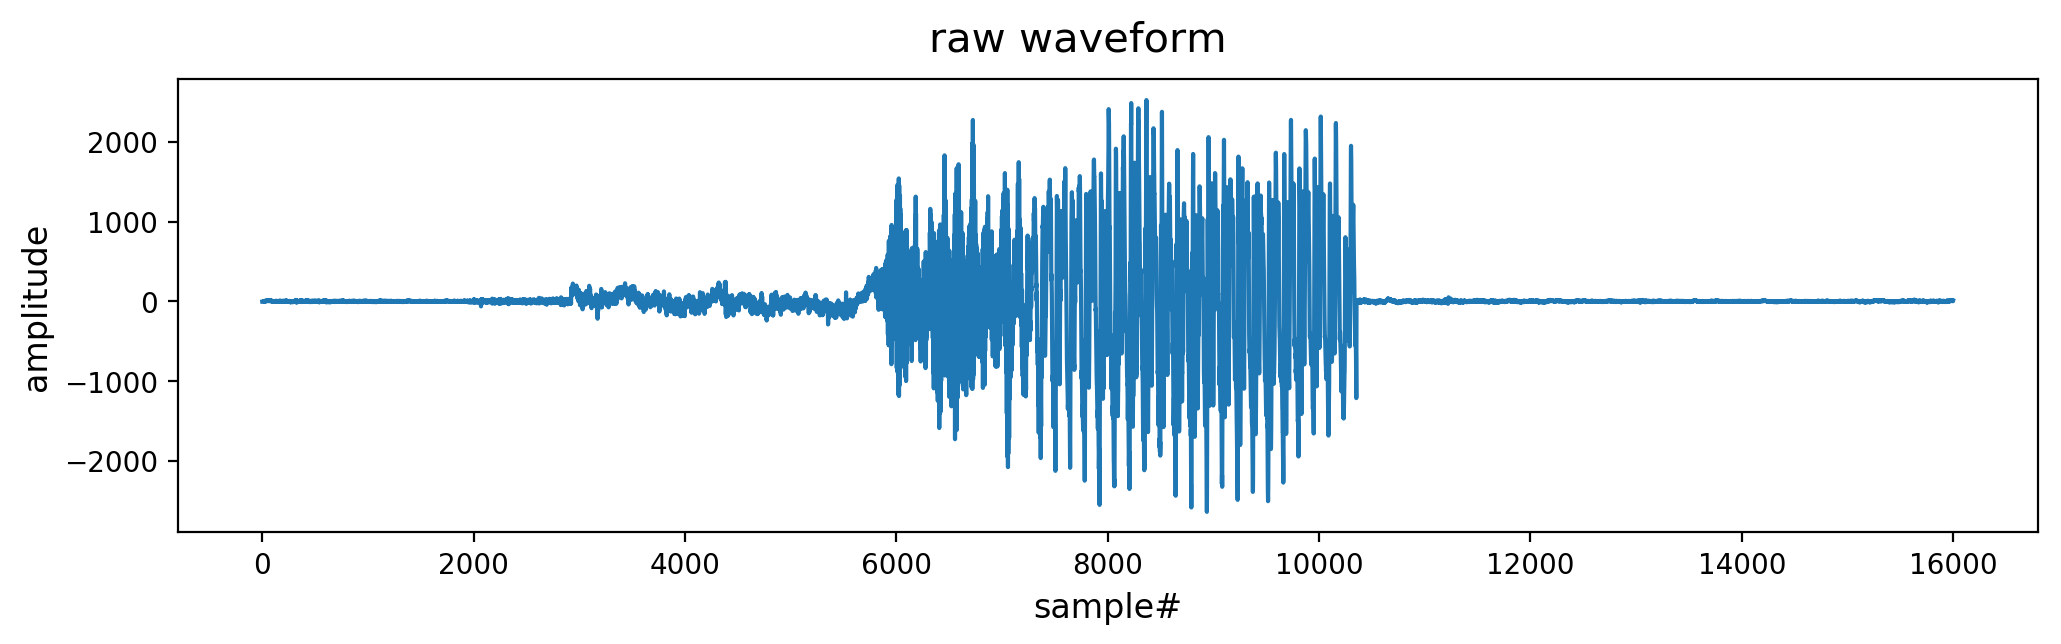

In [383]:
plot_waveform(noise)

In [384]:
ipd.Audio(noise, rate=sample_rate)

#### check the function to align waveform

In [455]:
def emphasize_signal(samples, pre_emphasis=0.97):
    ## y[t] = x[t] - pre_emphasis * x[t-1]
    return np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])

def max_sample_index(samples, std_window_length):
    std_array = pd.rolling_std(samples, std_window_length)
    std_array = std_array[std_window_length:]
    return np.argmax(std_array)
    
def align_wave_with_padding(file_name_, noise_file_name_, wav_window_length=3000, std_window_length=300):
    left_padding, right_padding = None, None
    sample_rate, samples = wavfile.read(file_name_)
    samples = emphasize_signal(samples)
    center_index = max_sample_index(samples, std_window_length)
    if center_index > wav_window_length:
        left_index = center_index - wav_window_length
        left_half = samples[left_index:center_index]
    else:
        left_padding = white_noise(noise_file_name_, (wav_window_length-center_index), 50)
        left_half = np.append(left_padding, samples[:center_index])
    if center_index + wav_window_length < len(samples):
        return np.append(left_half, samples[center_index:(center_index + wav_window_length)])
    else:
        right_padding = white_noise(noise_file_name_, (wav_window_length+center_index-len(samples)), 50)
        return np.concatenate((left_half, samples[center_index:], right_padding), axis=0)

In [456]:
noise_file_name = '/Users/matt.meng/data/speech_competition/train/audio/_background_noise_/dude_miaowing.wav'
#file_name = '/Users/matt.meng/data/speech_competition/train/audio/zero/a40c62f1_nohash_0.wav'
file_name = '/Users/matt.meng/data/speech_competition/train/audio/bird/3ff840aa_nohash_0.wav'
wav = align_wave_with_padding(file_name, noise_file_name, wav_window_length=8000)

/Users/matt.meng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  


In [457]:
def plot_waveform(samples_):
    if isinstance(samples_, str):
        sample_rate, samples_ = wavfile.read(samples_)
    print len(samples_)
    fig = plt.figure(figsize=(12, 3), dpi=200)
    plt.plot(samples_)
    fig.suptitle('raw waveform', fontsize=15)
    plt.xlabel('sample#', fontsize=12)
    plt.ylabel('amplitude', fontsize=12)


15360


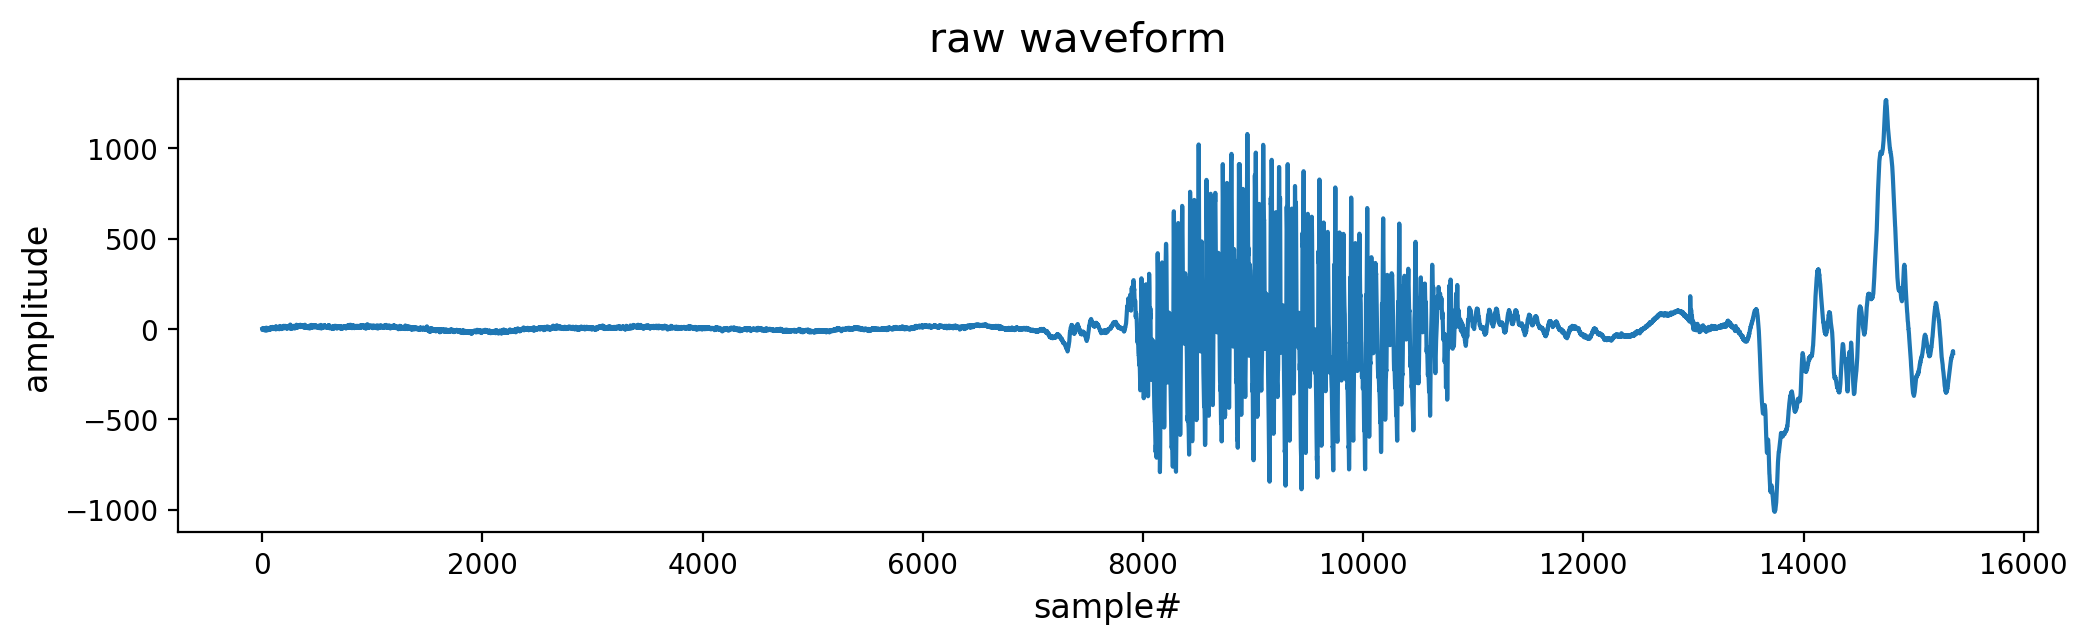

In [458]:
plot_waveform(file_name)

In [459]:
len(wav)

16000

16000


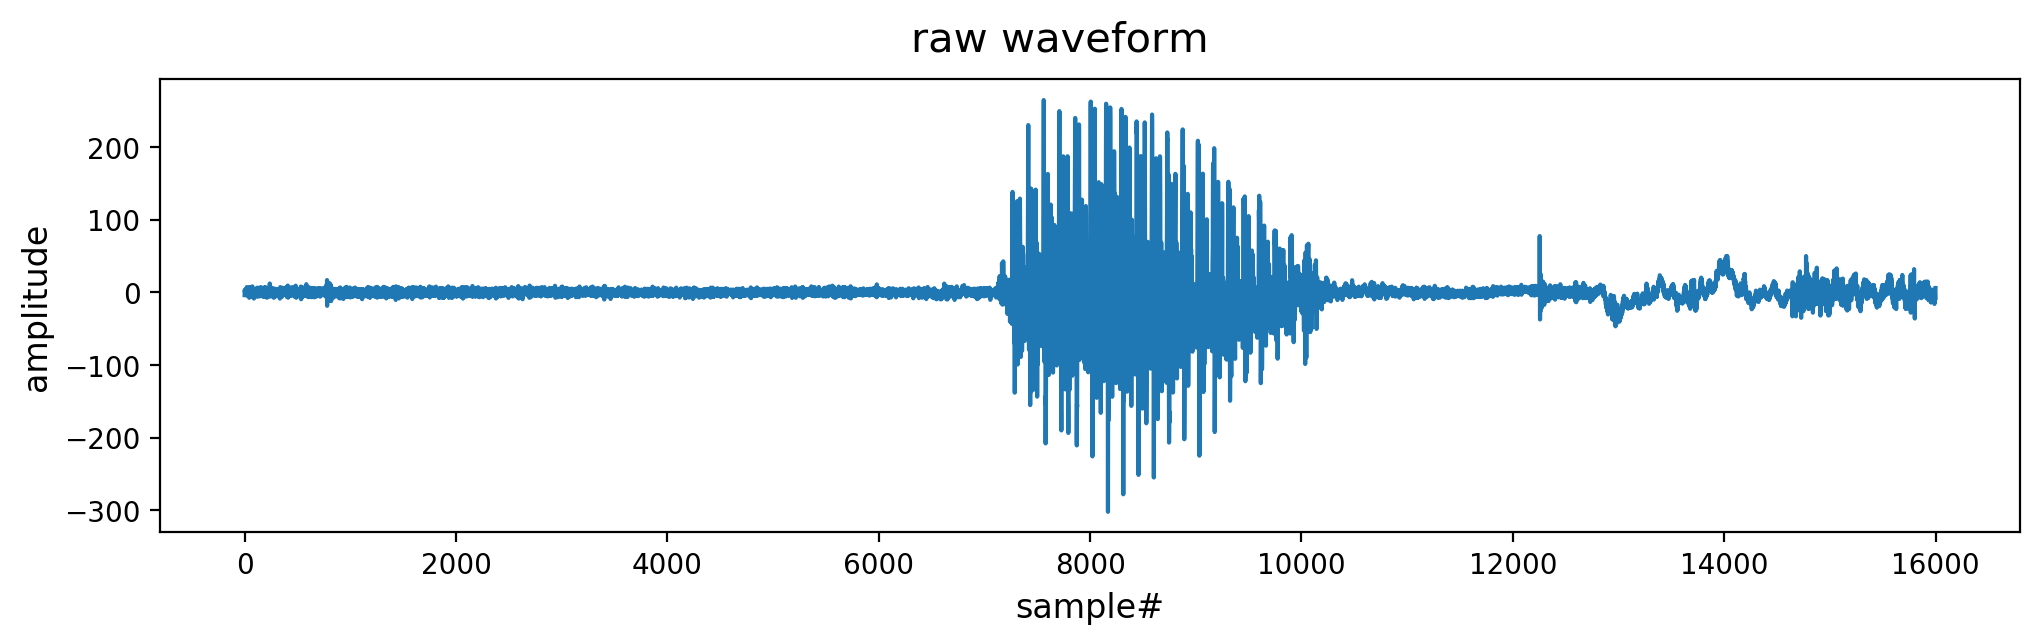

In [460]:
plot_waveform(wav)

In [461]:
ipd.Audio(wav, rate=sample_rate)

In [465]:
fbank_features = logfbank(wav, sample_rate)

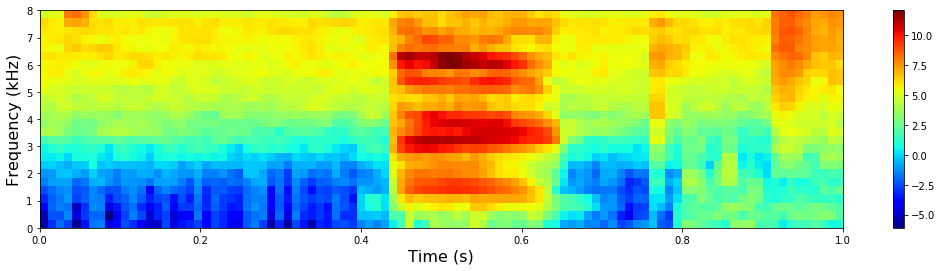

In [466]:
plot_spectrum(fbank_features, sample_rate)

#### check the peak index

In [462]:
def collect_wav_peaks(wav_files, length_filter=None):
    peak_index_list = []
    window_length = 500
    for wav_file in wav_files:
        word = re.search('.*/([^/]+)/.*.wav', wav_file).group(1).lower()
        if word == '_background_noise_':
            continue
        sample_rate, samples = wavfile.read(wav_file)
        if length_filter is not None and len(samples) == length_filter:
            continue
        samples = emphasize_signal(samples)
        std_array = pd.rolling_std(samples, window_length)
        std_array = std_array[window_length:]
        peak_index = np.argmax(std_array)
        peak_index_list.append(peak_index)
        #peak_index.append(np.argmax(samples))
        if peak_index > 14000:
            print wav_file
    return peak_index_list

In [463]:
peak_index = collect_wav_peaks(wav_files, 16000)

/Users/matt.meng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  if sys.path[0] == '':


/Users/matt.meng/data/speech_competition/train/audio/four/4254621e_nohash_0.wav
/Users/matt.meng/data/speech_competition/train/audio/house/23abe1c9_nohash_1.wav
/Users/matt.meng/data/speech_competition/train/audio/house/4f8ef132_nohash_0.wav
/Users/matt.meng/data/speech_competition/train/audio/house/a996cf66_nohash_0.wav
/Users/matt.meng/data/speech_competition/train/audio/left/83957201_nohash_0.wav
/Users/matt.meng/data/speech_competition/train/audio/left/c578beb0_nohash_0.wav
/Users/matt.meng/data/speech_competition/train/audio/right/7195ffa6_nohash_1.wav
/Users/matt.meng/data/speech_competition/train/audio/right/a1a59b72_nohash_0.wav
/Users/matt.meng/data/speech_competition/train/audio/yes/41285056_nohash_0.wav
/Users/matt.meng/data/speech_competition/train/audio/yes/7fc74fbe_nohash_0.wav


(array([   8.,    4.,    9.,   16.,   30.,   51.,   76.,  126.,  147.,
         252.,  340.,  420.,  525.,  634.,  662.,  655.,  607.,  519.,
         421.,  320.,  217.,  155.,   99.,   74.,   45.,   29.,   12.,
           6.,    4.,    6.]),
 array([     0. ,    497.7,    995.4,   1493.1,   1990.8,   2488.5,
          2986.2,   3483.9,   3981.6,   4479.3,   4977. ,   5474.7,
          5972.4,   6470.1,   6967.8,   7465.5,   7963.2,   8460.9,
          8958.6,   9456.3,   9954. ,  10451.7,  10949.4,  11447.1,
         11944.8,  12442.5,  12940.2,  13437.9,  13935.6,  14433.3,  14931. ]),
 <a list of 30 Patch objects>)

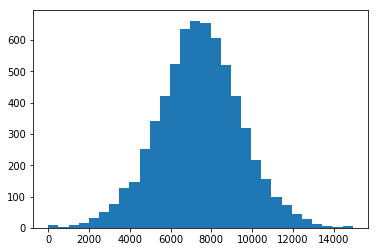

In [464]:
plt.hist(peak_index, bins=30)

In [127]:
for wav_file in wav_files:
    word = re.search('.*/([^/]+)/.*.wav', wav_file).group(1).lower()
    if word == '_background_noise_':
        continue
    sample_rate, samples = wavfile.read(wav_file)
    if len(samples) == 16000:
        continue
    peak_index = np.argmax(samples)
    if peak_index > 14000:
        print wav_file

/Users/matt.meng/data/speech_competition/train/audio/bird/3ff840aa_nohash_0.wav
/Users/matt.meng/data/speech_competition/train/audio/down/ea1f888c_nohash_0.wav
/Users/matt.meng/data/speech_competition/train/audio/happy/23abe1c9_nohash_0.wav
/Users/matt.meng/data/speech_competition/train/audio/right/da5dadb9_nohash_0.wav
/Users/matt.meng/data/speech_competition/train/audio/two/65f2531f_nohash_0.wav
/Users/matt.meng/data/speech_competition/train/audio/wow/9a3f97f8_nohash_0.wav
/Users/matt.meng/data/speech_competition/train/audio/zero/ad6a46f1_nohash_2.wav


#### validate the rolling std with `emphasize_signal` as a metric for peak search

In [424]:
file_name = wav_file_dict_['down'][8192][1]
#file_name = '/Users/matt.meng/data/speech_competition/train/audio/zero/ad6a46f1_nohash_2.wav'
file_name = '/Users/matt.meng/data/speech_competition/train/audio/bird/3ff840aa_nohash_0.wav'
print file_name
sample_rate, samples = wavfile.read(file_name)

/Users/matt.meng/data/speech_competition/train/audio/bird/3ff840aa_nohash_0.wav


In [425]:
len(samples), samples

(15360, array([  -1,   -5,   -3, ..., -128, -122, -133], dtype=int16))

In [426]:
len(samples)

15360

15360


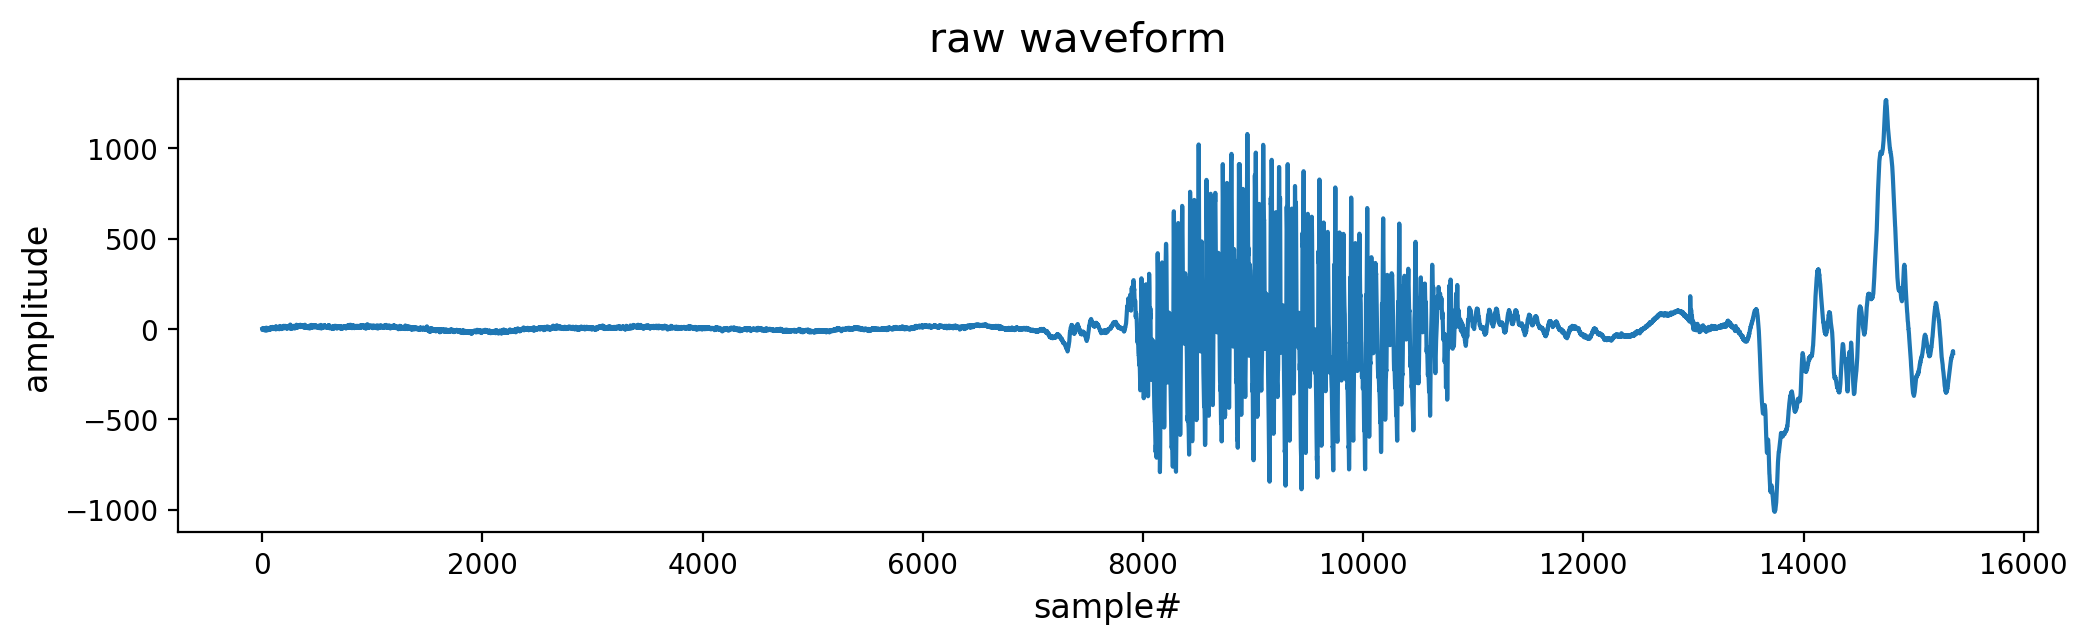

In [427]:
plot_waveform(samples)

In [429]:
emphasized_samples = emphasize_signal(samples)

15360


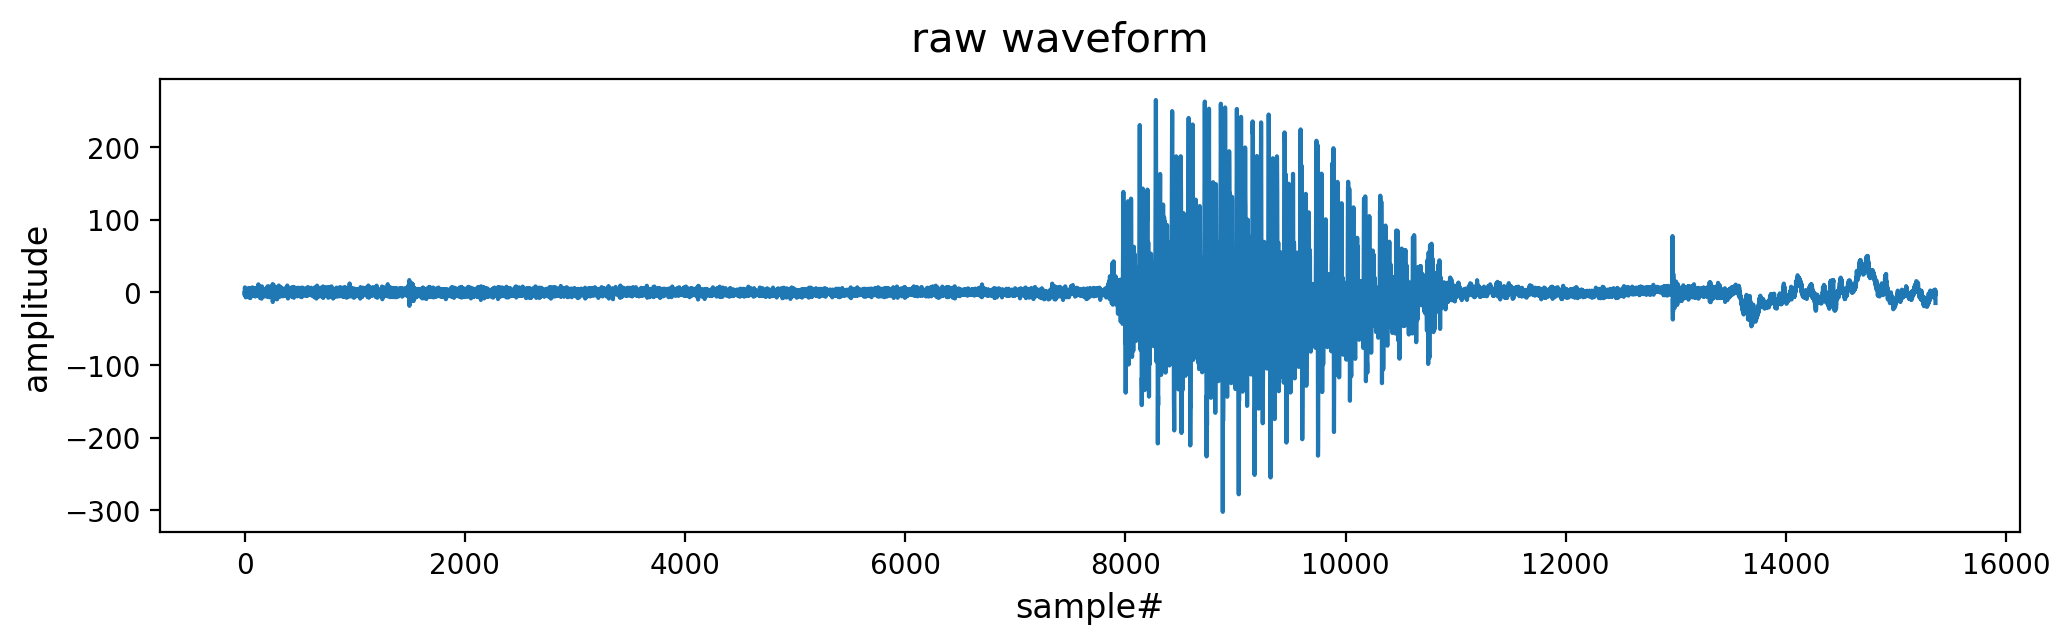

In [430]:
plot_waveform(emphasized_samples)

In [436]:
std_samples = pd.rolling_std(emphasized_samples, 500)

/Users/matt.meng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [437]:
len(std_samples)

15360

In [438]:
res[500:]

array([          nan,           nan,           nan, ...,  451.41892811,
        451.49885668,  451.59073975])

15360


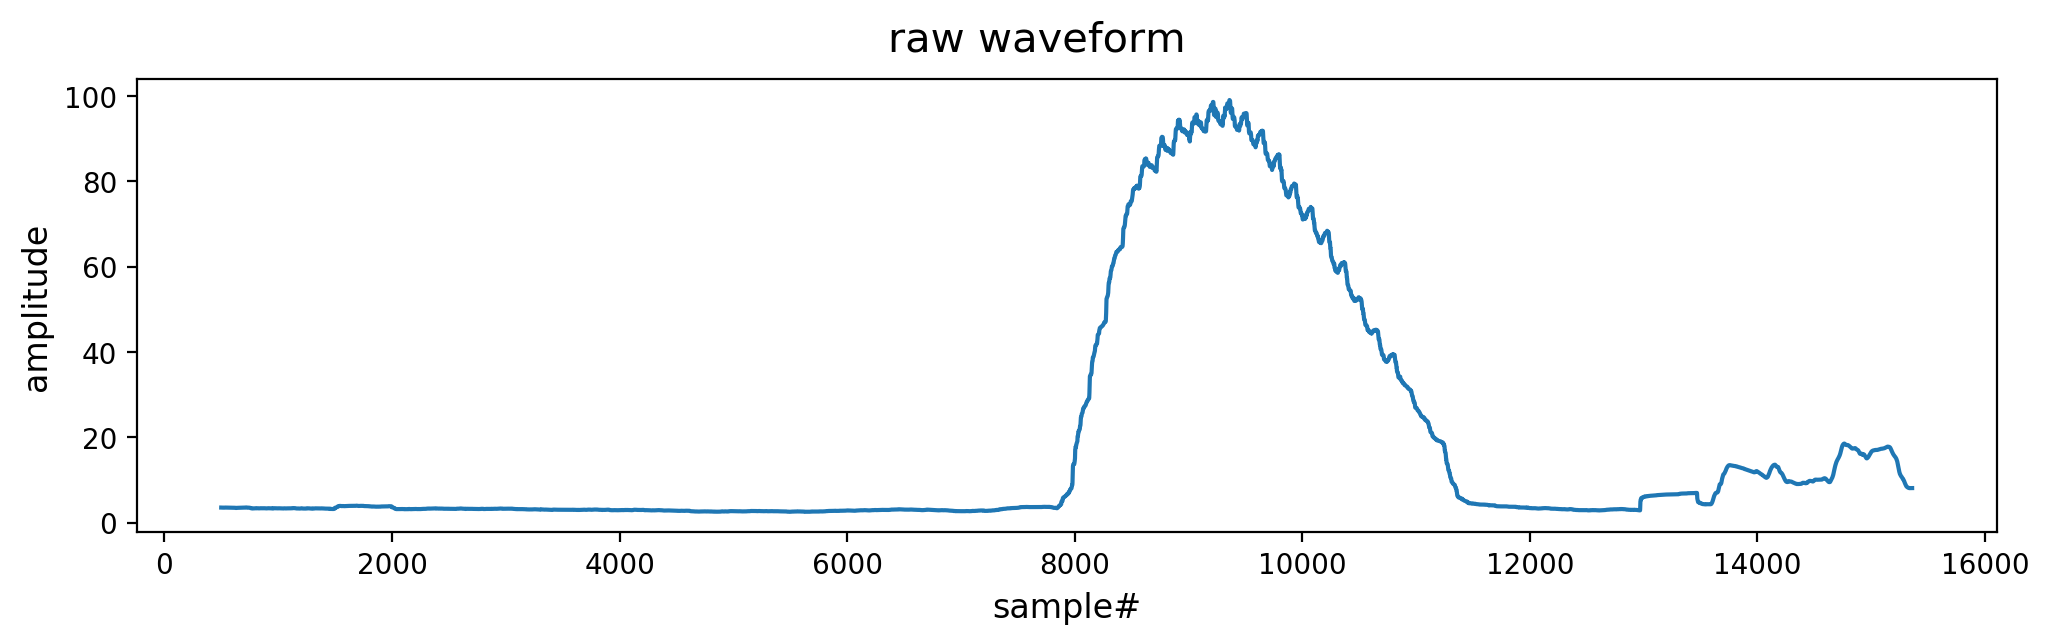

In [440]:
plot_waveform(std_samples)

In [143]:
smoothed_samples = smooth_by_moving_average(samples, 1000)

In [144]:
np.argmax(samples)

14379

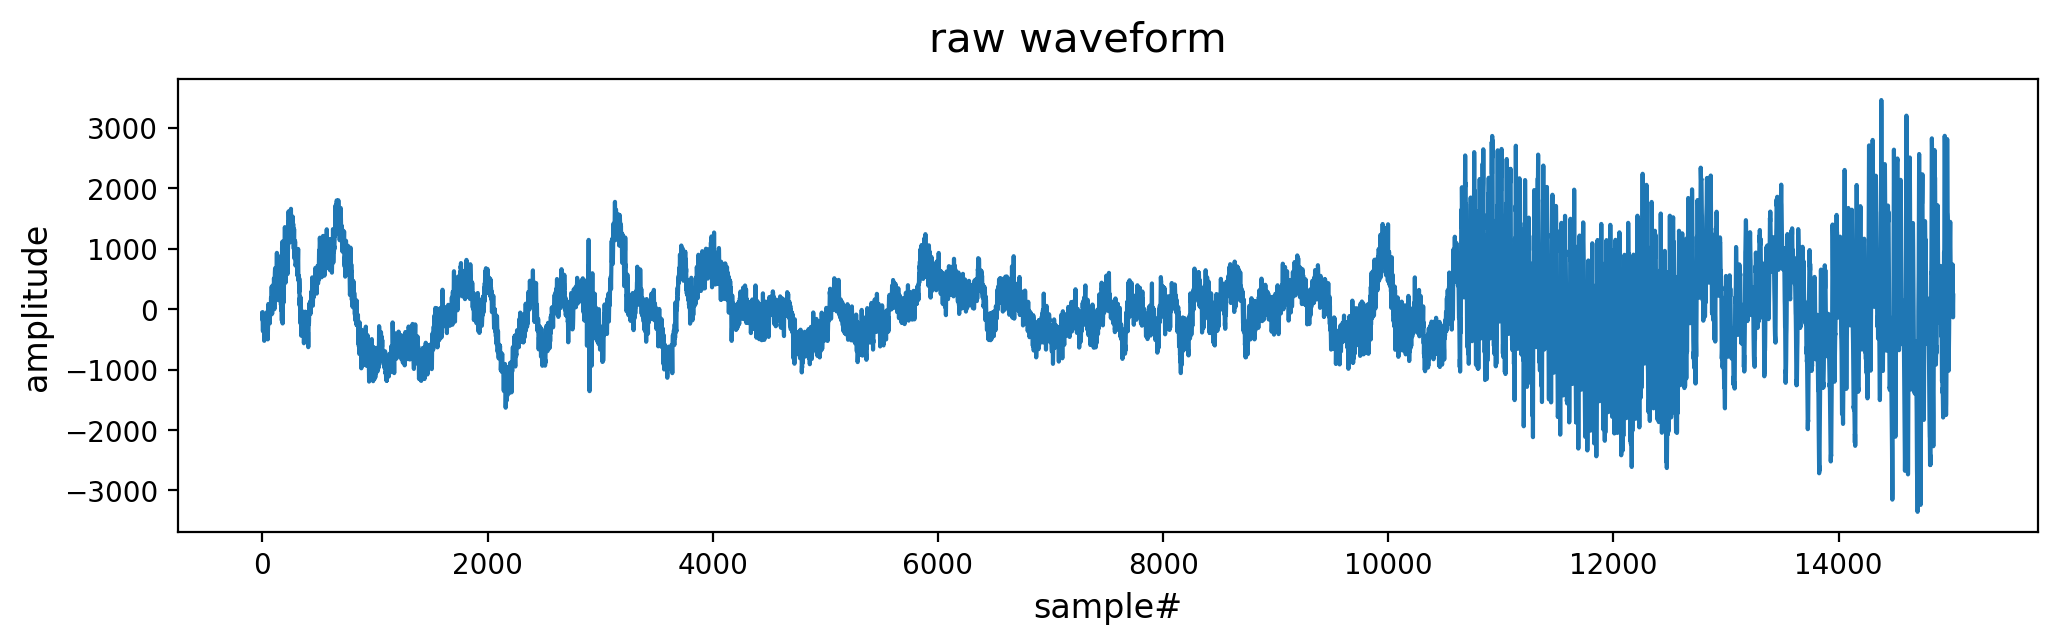

In [145]:
plot_waveform(samples)

In [146]:
ipd.Audio(samples, rate=sample_rate)

#### padded samples

In [106]:
padded_samples = pad_raw_waveform(samples)

In [107]:
len(padded_samples)

16000

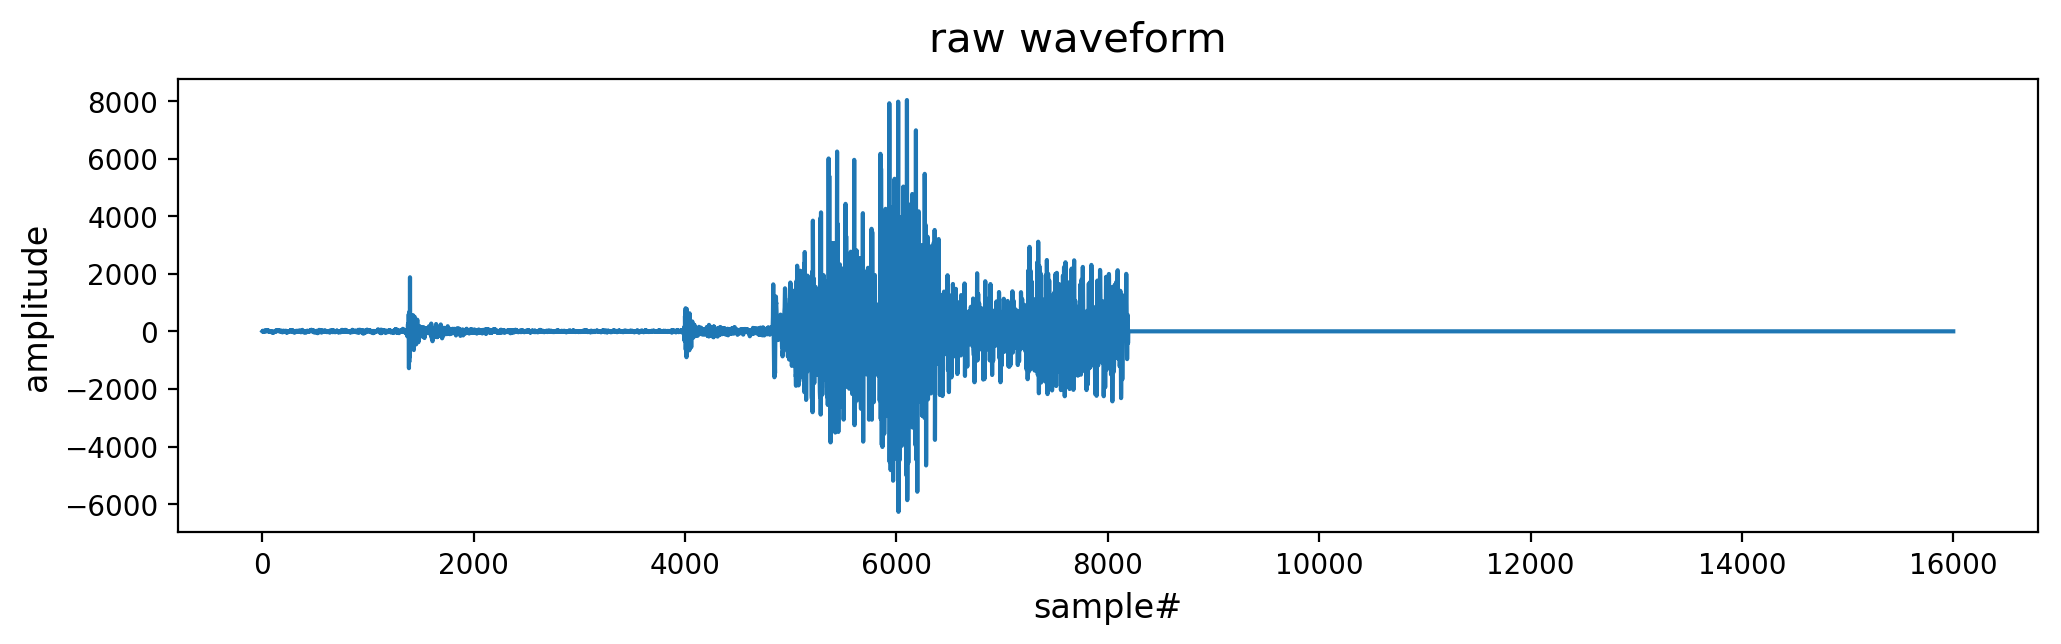

In [108]:
plot_waveform(padded_samples)

In [109]:
ipd.Audio(padded_samples, rate=sample_rate)

#### check the spectrum

In [110]:
fbank_features = logfbank(samples, sample_rate)

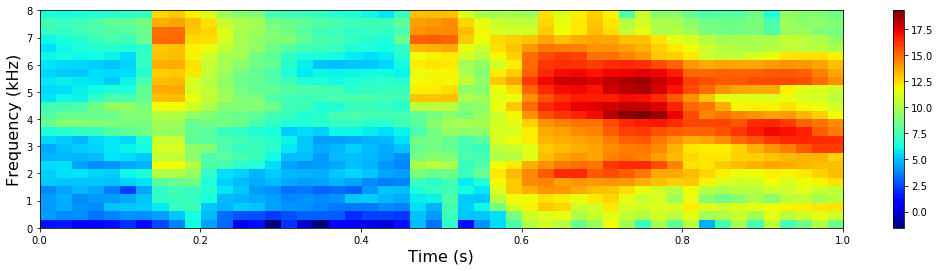

In [111]:
plot_spectrum(fbank_features, sample_rate)

In [93]:
padded_fbank_features = logfbank(padded_samples, sample_rate)

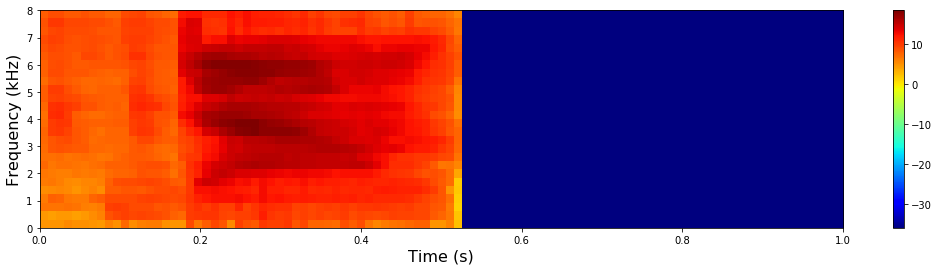

In [94]:
plot_spectrum(padded_fbank_features, sample_rate)

#### check the data format

In [22]:
hash_name = re.sub(r'_nohash_.*$', '', wav_files[20])

In [34]:
wav_files[26]

'/Users/matt.meng/data/speech_competition/train/audio/bed/035de8fe_nohash_0.wav'

In [42]:
hash_name = re.search('/([^/]+)sda', wav_files[26])

In [43]:
hash_name

#### load the fbank features from waveforms

In [117]:
pickle_file_path = '/Users/matt.meng/data/speech_competition/processed_data'
pickle_file = 'speech_training_0.pkl'

In [118]:
with open(os.path.join(pickle_file_path, pickle_file), 'rb') as f:
    data = pickle.load(f)

In [119]:
print len(data)

2000


In [122]:
print [elem[1] for elem in data[:20]]

[11, 2, 11, 1, 11, 0, 11, 3, 11, 11, 11, 11, 8, 2, 11, 2, 11, 9, 11, 11]
